In [1]:
import os
import json
import torch

from models import VPC_RNN
from train_tools import get_datasets, Logger, euclid

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
model_type = "RNN"
path = f"./models/al1_10_l2_0"
spec_file = f"{path}/model_parameters.json"
with open(spec_file, "r") as f:
    params = json.load(f)

In [3]:
print("Model Parameters: \n", json.dumps(params, indent = 5))

Model Parameters: 
 {
     "epochs": 100,
     "batch_size": 64,
     "lr": 0.0001,
     "al1": 10.0,
     "l2": 0,
     "nodes": 500,
     "outputs": 100,
     "reset_interval": 10,
     "context": true
}


In [4]:
model = VPC_RNN(params)
logger = Logger(path)

In [5]:
def initial_state(step, g, reset_interval):
    if (i % reset_interval) == 0:
        g_prev = None
    else:
        g_prev = g[:,-1].detach().clone() # persistent RNN state # keep final timestep for statefulness
    return g_prev

In [6]:
train_loader, val_loader = get_datasets("datasets/trajectories", context = params["context"], device = model.device,
                                        trajectories = True, batch_size = params["batch_size"])

for epoch in tqdm(range(params["epochs"])):
    # train step
    g_prev = None
    train_metrics = {"loss" : 0, "euclid" : 0}
    for i, (x_train, y_train) in enumerate(train_loader):
        inputs = (x_train, y_train)
        loss, yhat, g = model.train_step(inputs, y_train, g_prev)
        g_prev = initial_state(i+1, g, params["reset_interval"])
        train_metrics["loss"] += loss.item()
        train_metrics["euclid"] += euclid(y_train, yhat).item()
                      
    train_metrics = {key:train_metrics[key]/len(train_loader) for key in train_metrics}
    logger(train_metrics, "train")
    
    # validation step
    val_metrics = {"loss" : 0, "euclid" : 0}
    for j, (x_val, y_val) in enumerate(val_loader):

        inputs = (x_val, y_val)
        loss, yhat, g = model.val_step(inputs, y_val, g_prev)
        g_prev = initial_state(j+1, g, params["reset_interval"])

        val_metrics["loss"] += loss.item()
        val_metrics["euclid"] += euclid(y_val, yhat).item()
    val_metrics = {key:val_metrics[key]/len(val_loader) for key in val_metrics}
    logger(val_metrics, "val")

100%|██████████| 100/100 [20:52<00:00, 12.52s/it]


In [7]:
torch.save(model, f"{path}/trained_{model_type}_model")
logger.save_metrics(name = model_type)

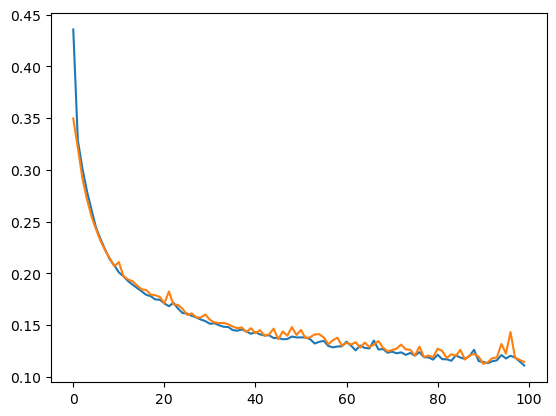

In [8]:
plt.plot(logger.metrics["train_euclid"])
plt.plot(logger.metrics["val_euclid"])